# Data Pre-processing

In [2]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action="ignore")

In [3]:
# 자치구별 인구의 경우, 2018년 데이터만 월별로 분류되어 있고 나머지는 연도별로 csv 제공. 따라서 2018년 데이터 concat 필요.

output_file = r'./population_data/population_2018.csv'
allData = []

for i in range(1, 13):
    df = pd.read_csv('./practice/LOCAL_PEOPLE_GU_2018/LOCAL_PEOPLE_GU_2018'+f'{i:02}.csv', encoding='CP949', index_col=False)
    allData.append(df)
    
dataCombine = pd.concat(allData, axis=0, ignore_index=False)
dataCombine.to_csv(output_file, index=False)

In [4]:
# 나머지 데이터도 인코딩 문제로 인해 read.csv 후 다시 내보내기

for i in range(19, 22):
    df = pd.read_csv('./practice/LOCAL_PEOPLE_GU_20'+f'{i:02}.csv', encoding='CP949', index_col=False)
    
    df.to_csv('./population_data/population_20'+f'{i:02}.csv', index=False)

In [6]:
population_2018 = pd.read_csv('./population_data/population_2018.csv')
population_2019 = pd.read_csv('./population_data/population_2019.csv')
population_2020 = pd.read_csv('./population_data/population_2020.csv')
population_2021 = pd.read_csv('./population_data/population_2021.csv')

In [7]:
population_2018.head()

,기준일ID,시간대구분,자치구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20180101,0,11110,256273.0604,6985.3617,3653.8530,6572.5156,12986.9063,13727.3330,10311.8520,...,11194.3415,8822.2477,8909.7811,8565.6805,9855.9650,8859.2694,8861.3758,8308.3461,6431.7669,20256.2884
1,20180101,0,11140,176621.0532,5326.5131,2013.1455,3188.3289,7176.6213,8599.4203,8232.7827,...,8013.3547,7496.8036,7325.9238,6097.7917,6448.4292,5640.9479,6457.4344,5974.6643,4284.3007,12887.8157
2,20180101,0,11170,293547.7332,7208.9039,3620.2581,5842.7592,11877.4543,15503.0524,14950.5011,...,16013.9886,13860.5926,12488.5361,11016.2786,10689.8140,8628.4710,9484.1050,8862.7852,6676.5444,22260.1984
3,20180101,0,11200,322848.8585,11390.5507,4888.1312,6877.0558,11178.1725,13050.0497,13011.7403,...,12355.4160,13270.0537,14314.5214,11909.4201,12261.6168,11291.1303,12796.9385,11436.0059,8521.6487,24522.9080
4,20180101,0,11215,398578.6493,11217.5545,5884.2123,12406.6133,18563.5674,18541.8660,16711.3371,...,18362.8934,16501.2107,16220.3905,13942.7155,15616.1077,14553.9676,15485.9605,13633.0170,9380.4592,24977.0013


In [8]:
population_2019.head()

,기준일ID,시간대구분,자치구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20190101,0,11110,247783.9476,6613.1044,3564.9470,6134.7190,12757.6730,13424.9912,9679.4043,...,11592.6358,8455.5240,8669.4651,7764.7926,9659.7779,8421.0455,8671.2045,8079.0106,6242.6970,17962.9680
1,20190101,0,11140,176516.2769,4735.9065,1857.9963,3251.4707,7456.5552,8482.9745,8253.8513,...,8654.7543,7425.3943,7345.0904,5858.8981,6255.6065,5525.2377,6293.4810,5906.2118,4298.7062,12303.3213
2,20190101,0,11170,287806.8492,7274.7405,3654.3768,5865.4531,11656.1407,15548.7770,14457.9881,...,16203.3581,13423.3780,13009.2350,10794.0704,10880.1619,8360.3558,9568.1641,8703.7465,6648.3724,20296.2431
3,20190101,0,11200,335106.5204,12278.8839,5306.1528,6766.7787,11593.4668,13941.8426,13447.0673,...,13656.2699,14046.9836,15142.1260,12029.9710,13051.1879,11475.2065,13219.4730,12022.8741,9093.4057,24370.0786
4,20190101,0,11215,399818.0269,12003.9916,6472.3827,12056.0837,17503.8179,18611.2942,16219.1953,...,17737.9096,16189.7277,16158.7700,14059.8023,15750.9307,14705.5715,15708.3156,14021.6731,9907.6266,24975.8391


In [9]:
population_2020.head()

,기준일ID,시간대구분,자치구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20200101,0,11110,248283.0355,6496.6713,3519.7135,6348.0673,12253.9712,12938.7039,9583.1787,...,11259.3854,8426.5599,8607.0974,8011.5248,9875.9187,8486.6664,9490.4589,8222.0645,6400.1665,17695.4216
1,20200101,0,11140,187720.0184,4655.7791,1817.9263,3500.9994,7226.0512,9428.2194,8787.5163,...,10079.4077,8195.3502,8308.9521,6605.4908,7053.0874,5983.3255,6620.2703,5915.9446,4544.3436,11603.8885
2,20200101,0,11170,292640.2683,7594.5578,3783.8774,6324.2591,11834.2528,15891.0504,14739.2364,...,16182.6128,13760.6577,13667.5186,10514.6813,11290.0344,8829.6365,9709.4967,8643.7729,6371.5681,18755.7771
3,20200101,0,11200,333267.7444,12520.2471,5415.8134,7182.9770,10466.6080,13383.5771,13654.5821,...,13626.2653,14261.8259,15999.6087,12892.9772,13062.3169,11207.5851,12904.2161,11578.6985,8481.8560,22570.1152
4,20200101,0,11215,390059.2798,12015.7622,6462.2537,12038.9403,16338.6258,18367.5701,15746.9044,...,18310.8330,16293.1891,16085.3865,13892.6067,15360.7202,14039.0758,14903.7537,13224.1186,9307.2924,22441.4454


In [10]:
population_2021.head()

,기준일ID,시간대구분,자치구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20210101,0,11110,194924.6184,4920.3837,2992.2011,4479.0239,7799.4338,8270.0476,6591.1392,...,7513.2691,6532.6210,7281.9873,7159.4938,8479.3144,7389.4164,8051.4425,6722.6436,5109.8562,15036.7700
1,20210101,0,11140,148826.8808,3354.1662,1376.5528,2368.3576,4868.7237,6945.7261,6640.6784,...,7110.3397,6713.5499,7244.8277,5420.8522,5795.2854,4829.2206,5617.3479,4846.5084,3847.0501,9823.1857
2,20210101,0,11170,250141.2136,7083.5939,3542.5572,5294.7572,7602.9197,9970.4226,11424.4500,...,10681.6414,11129.4982,12831.7555,10190.8974,10715.4628,8839.3659,9417.1985,8353.8373,5899.2935,16888.6424
3,20210101,0,11200,315490.0745,11513.7075,4873.2608,6427.3620,9447.8712,12296.0848,12453.8504,...,12707.7943,13462.4842,15997.2596,12525.5609,12903.9998,10991.7768,12442.7269,10785.3456,7925.9533,20678.4090
4,20210101,0,11215,360268.0149,10668.3623,5764.4680,9216.3402,12610.7515,16765.3160,15174.9819,...,17406.2677,15460.2633,15679.1837,13760.7719,14761.8863,13689.3575,14573.9438,12408.8341,8957.7143,20651.2597


In [25]:
# 각 자치구코드에 따라 살펴볼 4개구 데이터만 추출(광진구:11215, 동대문구:11230, 성동구:11200, 중랑구:11260)

population_2018_광진구 = population_2018[population_2018['자치구코드']==11215]
population_2019_광진구 = population_2019[population_2019['자치구코드']==11215]
population_2020_광진구 = population_2020[population_2020['자치구코드']==11215]
population_2021_광진구 = population_2021[population_2021['자치구코드']==11215]

population_2018_동대문구 = population_2018[population_2018['자치구코드']==11230]
population_2019_동대문구 = population_2019[population_2019['자치구코드']==11230]
population_2020_동대문구 = population_2020[population_2020['자치구코드']==11230]
population_2021_동대문구 = population_2021[population_2021['자치구코드']==11230]

population_2018_성동구 = population_2018[population_2018['자치구코드']==11200]
population_2019_성동구 = population_2019[population_2019['자치구코드']==11200]
population_2020_성동구 = population_2020[population_2020['자치구코드']==11200]
population_2021_성동구 = population_2021[population_2021['자치구코드']==11200]

population_2018_중랑구 = population_2018[population_2018['자치구코드']==11260]
population_2019_중랑구 = population_2019[population_2019['자치구코드']==11260]
population_2020_중랑구 = population_2020[population_2020['자치구코드']==11260]
population_2021_중랑구 = population_2021[population_2021['자치구코드']==11260]

In [99]:
# 시간대 0~24시로 나눠져있는 것을 하루 평균으로 합산

for i in range(18, 22):
    globals()['population_20{}_광진구'.format(i)] = globals()['population_20{}_광진구'.format(i)].groupby(['기준일ID'], as_index=False).mean()
    globals()['population_20{}_광진구'.format(i)].drop(['시간대구분'], axis=1, inplace=True)
    globals()['population_20{}_광진구'.format(i)] = globals()['population_20{}_광진구'.format(i)].astype({'자치구코드':'int'})
    
    globals()['population_20{}_동대문구'.format(i)] = globals()['population_20{}_동대문구'.format(i)].groupby(['기준일ID'], as_index=False).mean()
    globals()['population_20{}_동대문구'.format(i)].drop(['시간대구분'], axis=1, inplace=True)
    globals()['population_20{}_동대문구'.format(i)] = globals()['population_20{}_동대문구'.format(i)].astype({'자치구코드':'int'})
    
    globals()['population_20{}_성동구'.format(i)] = globals()['population_20{}_성동구'.format(i)].groupby(['기준일ID'], as_index=False).mean()
    globals()['population_20{}_성동구'.format(i)].drop(['시간대구분'], axis=1, inplace=True)
    globals()['population_20{}_성동구'.format(i)] = globals()['population_20{}_성동구'.format(i)].astype({'자치구코드':'int'})
    
    globals()['population_20{}_중랑구'.format(i)] = globals()['population_20{}_중랑구'.format(i)].groupby(['기준일ID'], as_index=False).mean()
    globals()['population_20{}_중랑구'.format(i)].drop(['시간대구분'], axis=1, inplace=True)
    globals()['population_20{}_중랑구'.format(i)] = globals()['population_20{}_중랑구'.format(i)].astype({'자치구코드':'int'})

In [100]:
population_2018_광진구

,기준일ID,자치구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20180101,11215,393345.678225,11449.460283,6005.913513,11036.268233,17376.875638,18164.074767,16429.685087,16244.708317,...,18047.449092,16322.250183,16261.671158,14005.044171,15612.269683,14505.780479,15459.748300,13492.873150,9425.760604,24834.660325
1,20180102,11215,382517.045679,11234.801908,5947.457475,10291.638437,17121.238092,17072.410333,15031.583988,15152.807683,...,17581.747054,15836.382550,15871.241942,13781.768854,15242.471950,14309.736942,15609.902908,13570.203783,9336.692883,24909.163283
2,20180103,11215,382217.030558,11389.031892,6027.913100,10318.482542,17160.287521,17178.913000,14783.006575,15002.728025,...,17712.369283,15807.587508,15980.658288,13777.729571,15290.283133,14373.063617,15654.833667,13414.398746,9331.618408,24731.722571
3,20180104,11215,385288.940454,11417.668888,6031.213013,10418.366371,17502.012637,17122.562458,14829.600737,15019.204979,...,17846.941342,15929.265104,15978.756150,13960.088321,15522.809642,14556.426983,15847.362933,13536.022333,9399.773762,24725.456521
4,20180105,11215,385062.260242,11419.211250,6064.210650,10622.343017,17640.773037,17408.322917,14907.844875,15064.659612,...,17845.741350,15877.435925,15800.991196,13880.348608,15475.176367,14368.171208,15729.877750,13474.341071,9247.700237,24825.555904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,20181227,11215,389765.244067,12664.160121,6910.761804,10047.286433,17131.222075,17474.415567,14507.064725,15038.630446,...,17952.113233,15685.026154,15995.783646,13993.044125,15565.821254,14558.501937,15861.347825,13995.853550,9934.092729,24474.875642
361,20181228,11215,390737.186175,12724.899879,6892.586800,10171.077733,17133.913329,17959.676571,14766.487117,15360.119671,...,17899.373183,15642.624650,15937.952688,13926.968342,15605.769567,14472.886700,15859.909338,13786.785633,9930.507642,24450.301071
362,20181229,11215,399021.332658,12387.182075,6624.347025,10295.393092,17377.331496,19369.773487,16044.131771,16210.331129,...,19097.320125,16466.468325,16301.779175,14205.435096,15798.504417,14600.253512,15828.842167,13904.538425,9881.263675,24455.424392
363,20181230,11215,395908.430525,12414.252663,6623.459604,10169.710867,16921.930421,19124.768304,16031.319483,16188.496696,...,18658.332758,16188.166242,16145.730096,13873.863617,15593.463742,14615.497679,15657.705167,13894.727258,9994.493596,24465.706783


In [101]:
print(population_2018_광진구.shape[0])
print(population_2019_광진구.shape[0])
print(population_2020_광진구.shape[0])
print(population_2021_광진구.shape[0])

365
352
366
365


In [111]:
# 현재 2019년 데이터 행이 352개로 결측값 있는 것으로 확인. train.csv에서도 해당 기간 제거 작업 필요.

for i in range(0, len(population_2019_광진구)):
    print(population_2019_광진구['기준일ID'].loc[i])
    
#20191015~20191027 데이터 없는 것 확인

20190101
20190102
20190103
20190104
20190105
20190106
20190107
20190108
20190109
20190110
20190111
20190112
20190113
20190114
20190115
20190116
20190117
20190118
20190119
20190120
20190121
20190122
20190123
20190124
20190125
20190126
20190127
20190128
20190129
20190130
20190131
20190201
20190202
20190203
20190204
20190205
20190206
20190207
20190208
20190209
20190210
20190211
20190212
20190213
20190214
20190215
20190216
20190217
20190218
20190219
20190220
20190221
20190222
20190223
20190224
20190225
20190226
20190227
20190228
20190301
20190302
20190303
20190304
20190305
20190306
20190307
20190308
20190309
20190310
20190311
20190312
20190313
20190314
20190315
20190316
20190317
20190318
20190319
20190320
20190321
20190322
20190323
20190324
20190325
20190326
20190327
20190328
20190329
20190330
20190331
20190401
20190402
20190403
20190404
20190405
20190406
20190407
20190408
20190409
20190410
20190411
20190412
20190413
20190414
20190415
20190416
20190417
20190418
20190419
20190420
20190421
2

In [114]:
# 지역구별로 2018~2020 Data Concat

population_광진구 = pd.concat([population_2018_광진구, population_2019_광진구, population_2020_광진구])
population_동대문구 = pd.concat([population_2018_동대문구, population_2019_동대문구, population_2020_동대문구])
population_성동구 = pd.concat([population_2018_성동구, population_2019_성동구, population_2020_성동구])
population_중랑구 = pd.concat([population_2018_중랑구, population_2019_중랑구, population_2020_중랑구])

# Data Visualization

In [76]:
def get_view_df(df):
    viewd = df[['기준일ID', '총생활인구수']]
    viewd = viewd.reset_index(drop = True)
    viewd = viewd.reset_index()
    sns.set(rc = {'figure.figsize': (30,8)})
    sns.lineplot(x = 'index', y = '총생활인구수', data = viewd)
    plt.show()

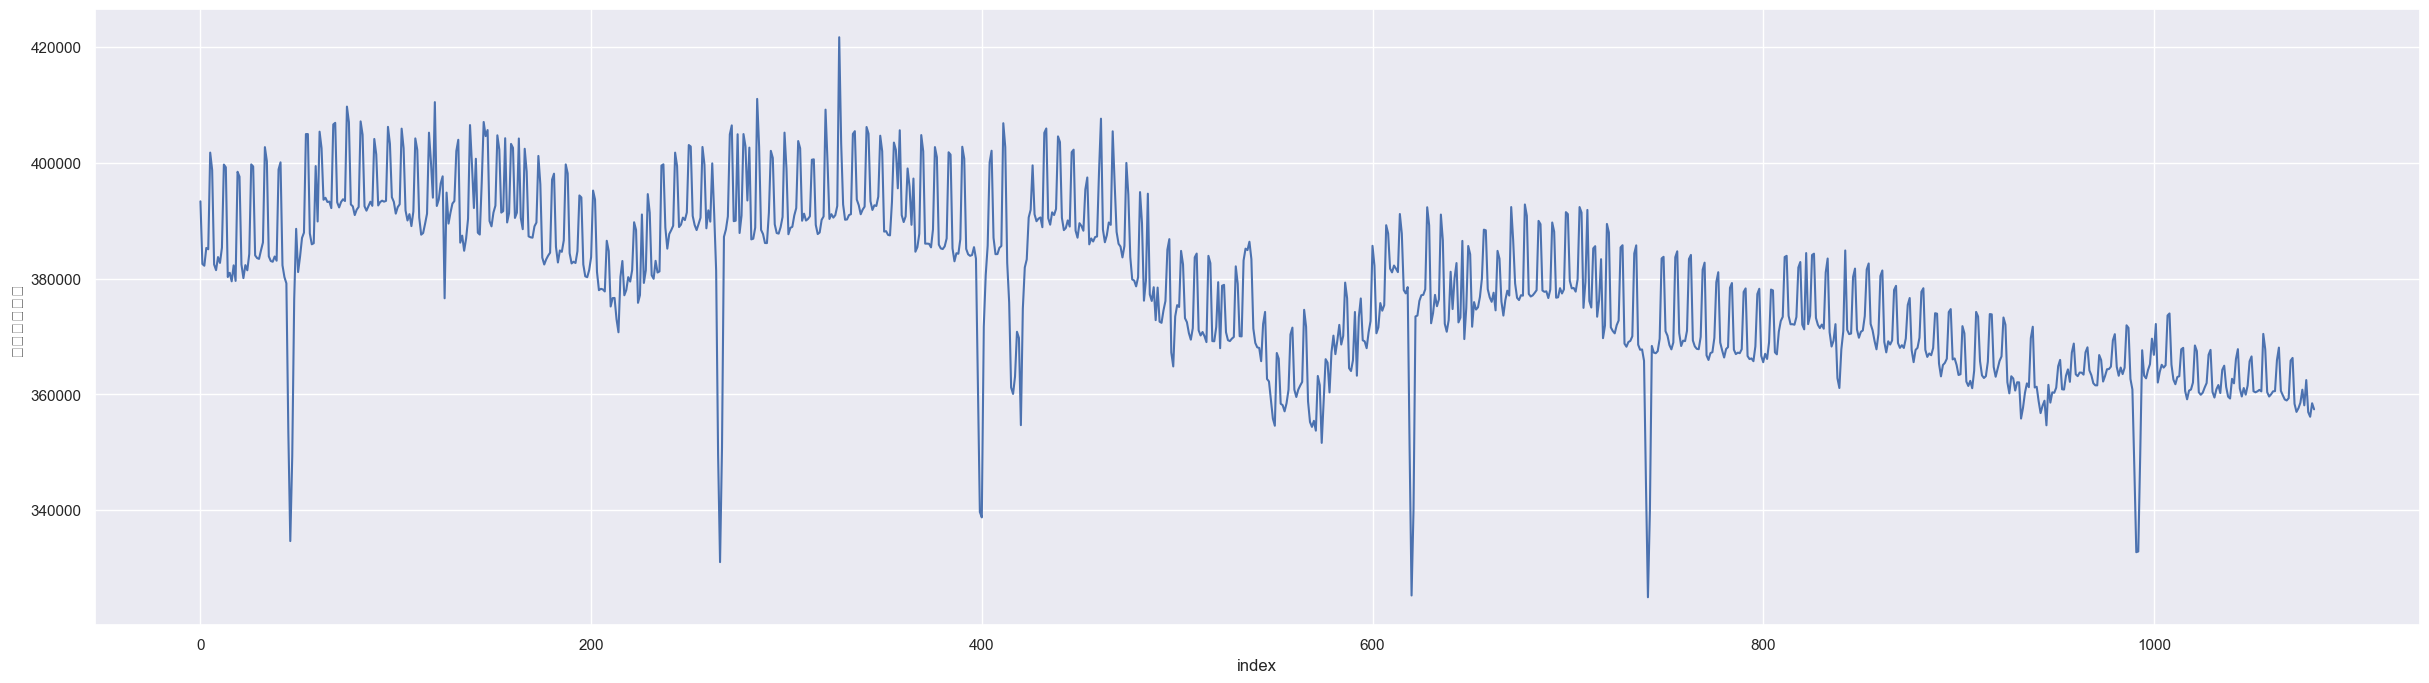

In [115]:
get_view_df(population_광진구)

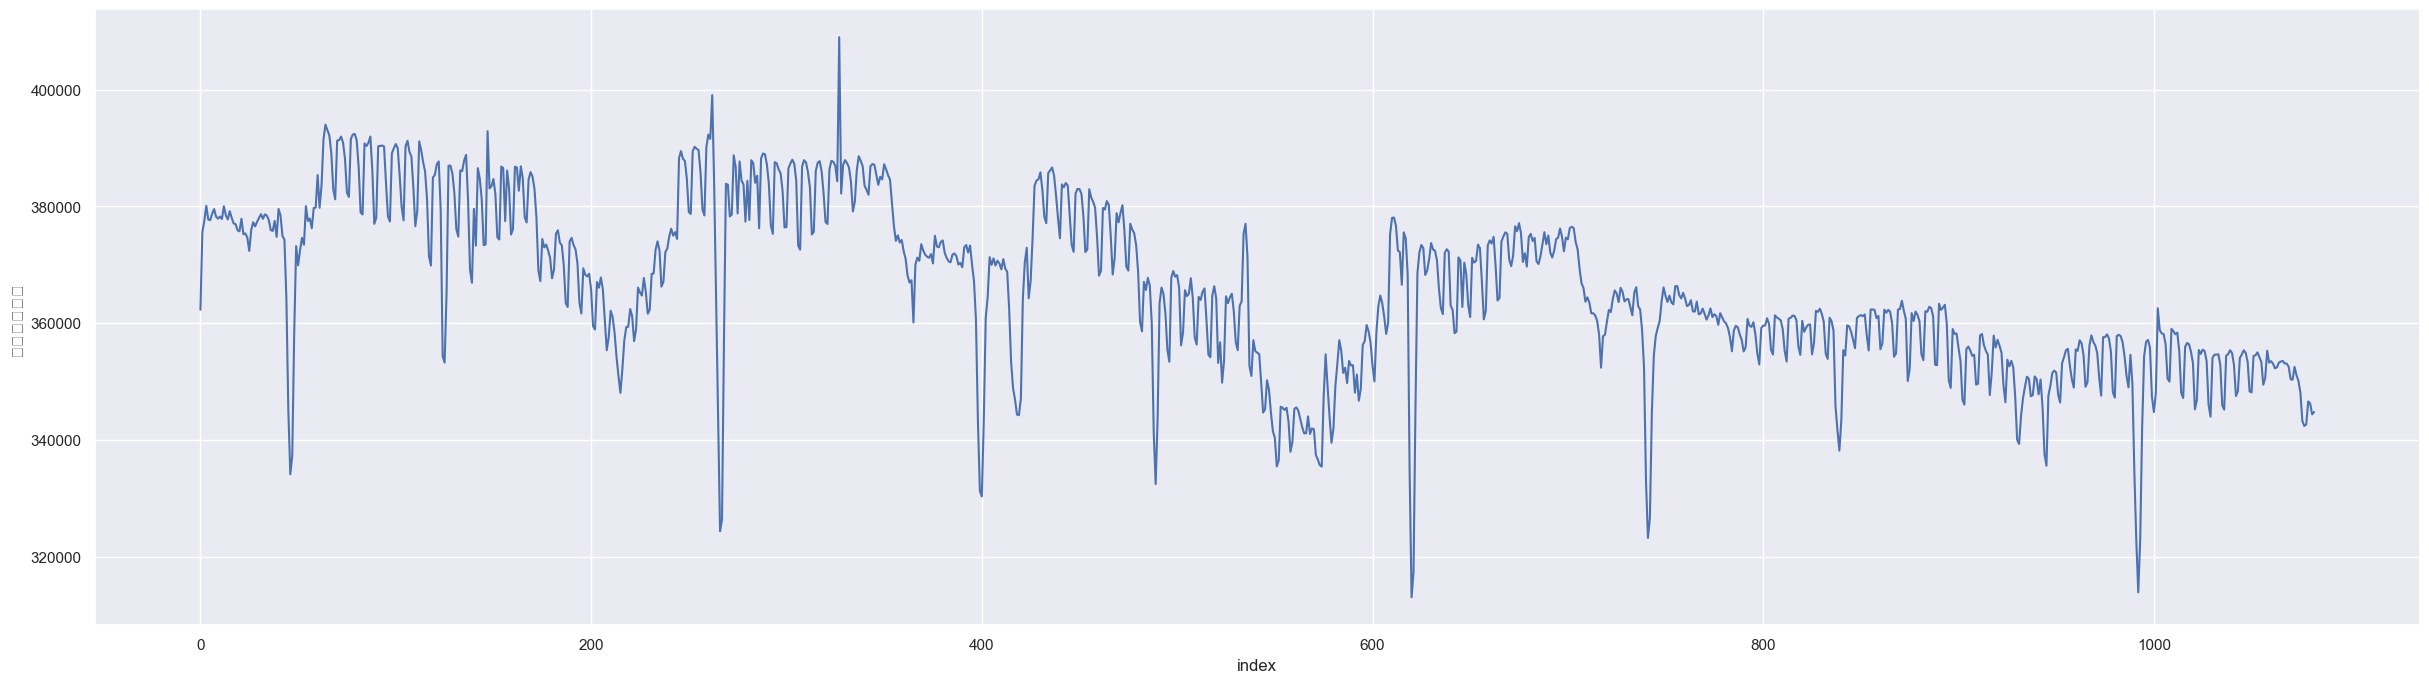

In [116]:
get_view_df(population_동대문구)

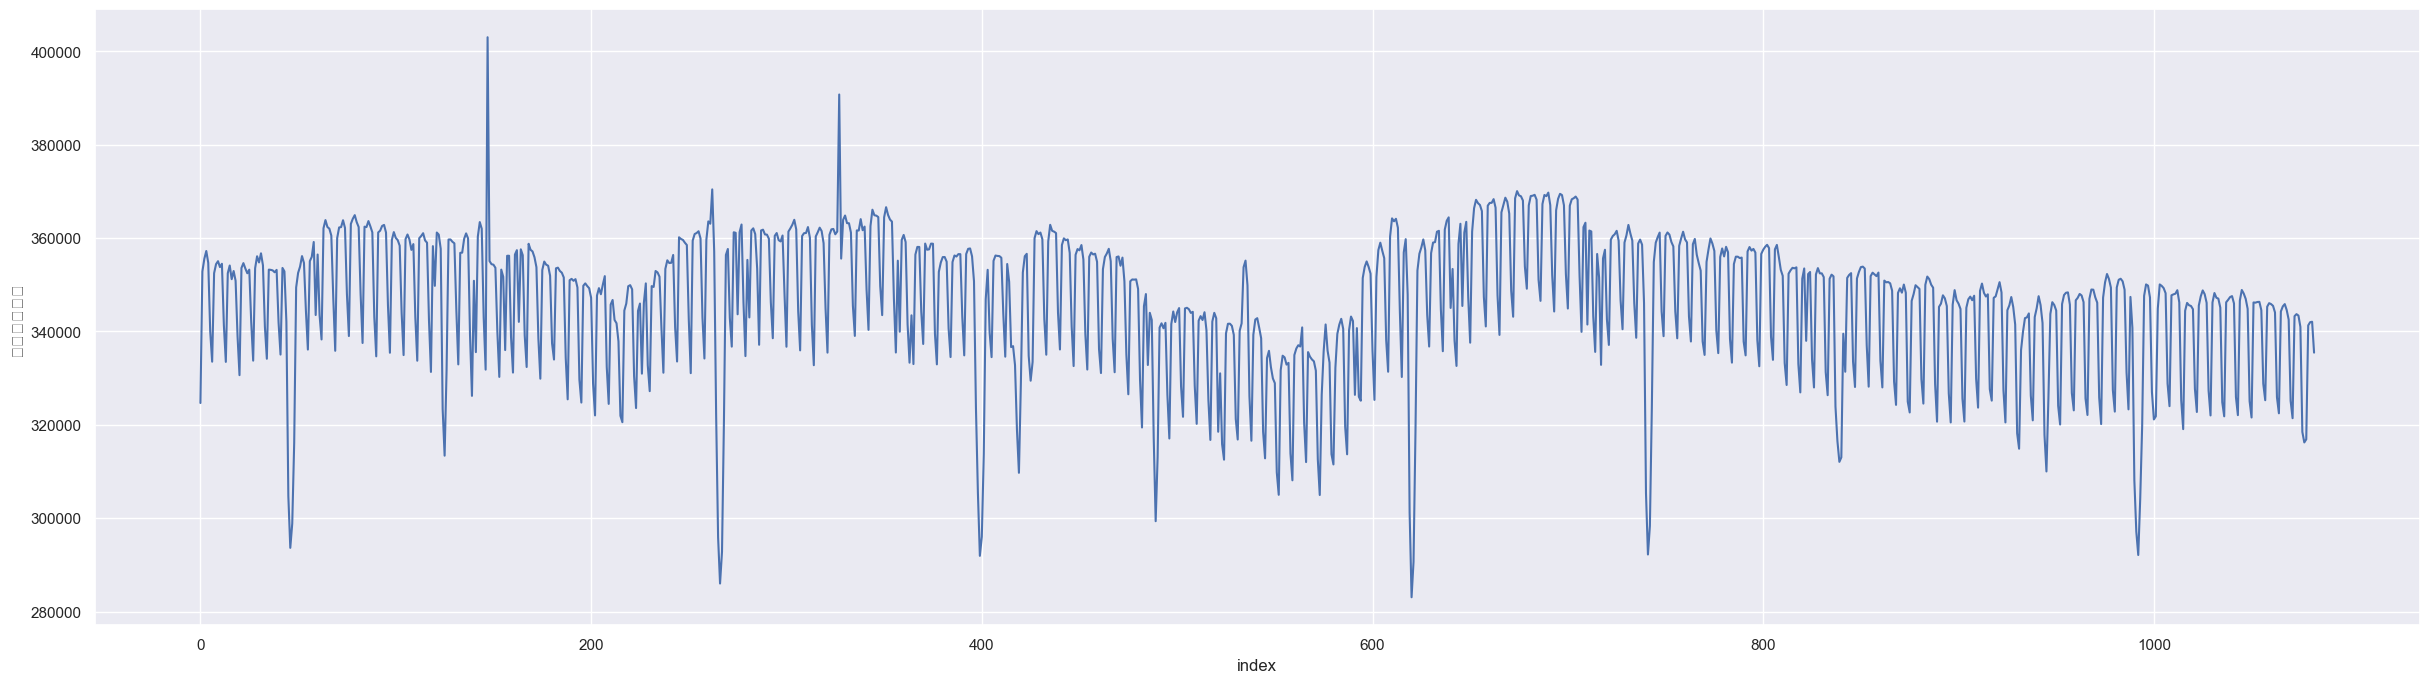

In [117]:
get_view_df(population_성동구)

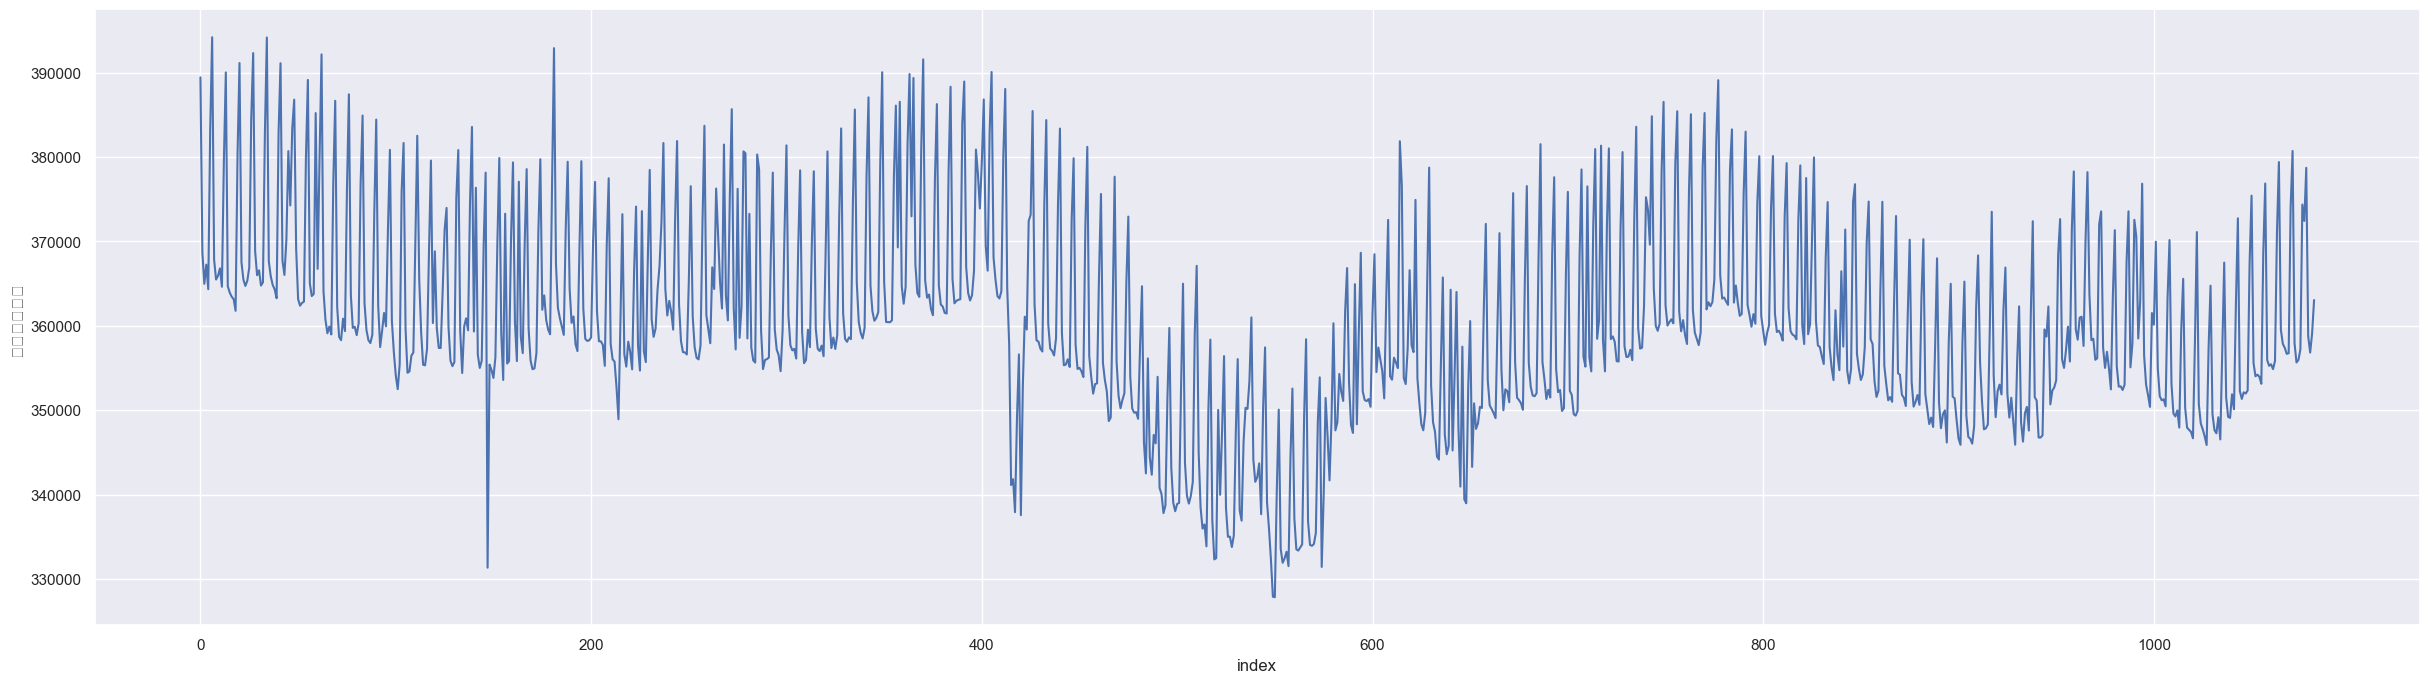

In [118]:
get_view_df(population_중랑구)

# Train/Validation Split

In [126]:
train_df = pd.read_csv('./open/train.csv')

In [168]:
# 2018~2020을 train, 2021을 validation으로 사용

y_val = train_df.iloc[1096:].reset_index().drop(columns='index') # 20210101 ~ 20211231
y_train = train_df.iloc[:1096].reset_index().drop(columns='index') # 20180101 ~ 20201231

In [169]:
y_train

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1091,20201227,3.528,2.604,3.258,2.038
1092,20201228,4.542,3.588,4.506,2.480
1093,20201229,3.694,3.054,3.222,2.118
1094,20201230,2.366,1.812,2.012,1.174


In [170]:
# y_train에서 20191015~20191027 제거 작업

print(y_train[y_train['일시']==20191015].index)
print(y_train[y_train['일시']==20191027].index)

Int64Index([652], dtype='int64')
Int64Index([664], dtype='int64')


In [171]:
y_train_1 = y_train.iloc[:652]
y_train_2 = y_train.iloc[665:]

In [172]:
y_train = pd.concat([y_train_1, y_train_2])

In [175]:
y_train

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1091,20201227,3.528,2.604,3.258,2.038
1092,20201228,4.542,3.588,4.506,2.480
1093,20201229,3.694,3.054,3.222,2.118
1094,20201230,2.366,1.812,2.012,1.174


# Regression

In [208]:
y_train_광진구 = torch.FloatTensor(y_train[['광진구']].values)
y_train_동대문구 = torch.FloatTensor(y_train[['동대문구']].values)
y_train_성동구 = torch.FloatTensor(y_train[['성동구']].values)
y_train_중랑구 = torch.FloatTensor(y_train[['중랑구']].values)

In [335]:
y_train_광진구

tensor([[0.5920],
        [0.8400],
        [0.8280],
        ...,
        [3.6940],
        [2.3660],
        [2.3660]])

In [276]:
# 따릉이 데이터가 천명 단위이므로 인구 데이터도 천명 단위로 맞춰줌

x_train_광진구 = torch.FloatTensor(population_광진구[['총생활인구수']].values/1000)
x_train_동대문구 = torch.FloatTensor(population_동대문구[['총생활인구수']].values/1000)
x_train_성동구 = torch.FloatTensor(population_성동구[['총생활인구수']].values/1000)
x_train_중랑구 = torch.FloatTensor(population_중랑구[['총생활인구수']].values/1000)

In [333]:
x_train_광진구

tensor([[393.3457],
        [382.5171],
        [382.2170],
        ...,
        [356.1210],
        [358.4522],
        [357.4039]])

In [336]:
torch.manual_seed(1)
model = nn.Linear(1,1)
# optimizer 설정. 경사 하강법 SGD 사용하고, lr = 0.000001
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

nb_epochs = 10000
for epoch in range(nb_epochs+1):
    
    # H(x) 계산
    prediction = model(x_train_광진구)
    
    # cost 계산
    cost = F.mse_loss(prediction, y_train_광진구)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, cost.item()
        ))

Epoch    0/10000 Cost: 35948.691406
Epoch 1000/10000 Cost: 11.155341
Epoch 2000/10000 Cost: 11.155332
Epoch 3000/10000 Cost: 11.155322
Epoch 4000/10000 Cost: 11.155313
Epoch 5000/10000 Cost: 11.155305
Epoch 6000/10000 Cost: 11.155296
Epoch 7000/10000 Cost: 11.155287
Epoch 8000/10000 Cost: 11.155278
Epoch 9000/10000 Cost: 11.155268
Epoch 10000/10000 Cost: 11.155261


In [337]:
print(list(model.parameters()))

[Parameter containing:
tensor([[0.0155]], requires_grad=True), Parameter containing:
tensor([-0.4418], requires_grad=True)]


In [338]:
x_val_광진구 = torch.FloatTensor(population_2021_광진구[['총생활인구수']].values/1000)
y_pred_광진구 = model(x_val_광진구)
print(y_pred_광진구)

# 무의미한 것 같은데..

tensor([[5.0888],
        [5.1067],
        [5.2264],
        [5.0942],
        [5.1049],
        [5.1230],
        [5.1395],
        [5.1374],
        [5.2722],
        [5.2864],
        [5.1192],
        [5.1245],
        [5.1211],
        [5.1214],
        [5.1177],
        [5.2385],
        [5.2565],
        [5.1163],
        [5.1141],
        [5.1199],
        [5.1239],
        [5.1432],
        [5.2577],
        [5.2641],
        [5.1238],
        [5.1040],
        [5.1093],
        [5.1154],
        [5.1390],
        [5.2620],
        [5.2690],
        [5.1342],
        [5.1244],
        [5.1180],
        [5.1194],
        [5.1168],
        [5.2340],
        [5.2435],
        [5.0957],
        [5.0743],
        [5.0584],
        [4.8798],
        [4.7017],
        [4.7957],
        [5.0802],
        [5.0804],
        [5.1040],
        [5.1140],
        [5.1348],
        [5.1394],
        [5.2525],
        [5.2683],
        [5.1168],
        [5.1069],
        [5.1053],
        [5

In [339]:
torch.manual_seed(1)
model = nn.Linear(1,1)
# optimizer 설정. 경사 하강법 SGD 사용하고, lr = 0.000001
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

nb_epochs = 10000
for epoch in range(nb_epochs+1):
    
    # H(x) 계산
    prediction = model(x_train_동대문구)
    
    # cost 계산
    cost = F.mse_loss(prediction, y_train_동대문구)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, cost.item()
        ))

Epoch    0/10000 Cost: 34194.929688
Epoch 1000/10000 Cost: 4.638744
Epoch 2000/10000 Cost: 4.638737
Epoch 3000/10000 Cost: 4.638730
Epoch 4000/10000 Cost: 4.638723
Epoch 5000/10000 Cost: 4.638715
Epoch 6000/10000 Cost: 4.638709
Epoch 7000/10000 Cost: 4.638701
Epoch 8000/10000 Cost: 4.638694
Epoch 9000/10000 Cost: 4.638687
Epoch 10000/10000 Cost: 4.638680


In [327]:
print(list(model.parameters()))

[Parameter containing:
tensor([[0.0104]], requires_grad=True), Parameter containing:
tensor([-0.4419], requires_grad=True)]


In [340]:
x_val_동대문구 = torch.FloatTensor(population_2021_동대문구[['총생활인구수']].values/1000)
y_pred_동대문구 = model(x_val_동대문구)
print(y_pred_동대문구)

# 무의미한 것 같은데..

tensor([[3.0525],
        [3.0638],
        [3.1238],
        [3.1662],
        [3.1705],
        [3.1696],
        [3.1648],
        [3.1641],
        [3.1777],
        [3.1727],
        [3.1750],
        [3.1771],
        [3.1756],
        [3.1819],
        [3.1681],
        [3.1763],
        [3.1580],
        [3.1762],
        [3.1747],
        [3.1839],
        [3.1755],
        [3.1675],
        [3.1608],
        [3.1288],
        [3.1680],
        [3.1617],
        [3.1708],
        [3.1667],
        [3.1567],
        [3.1657],
        [3.1470],
        [3.1852],
        [3.1825],
        [3.1855],
        [3.1795],
        [3.1808],
        [3.1682],
        [3.1521],
        [3.1738],
        [3.1471],
        [3.1022],
        [2.9652],
        [2.8692],
        [2.8575],
        [3.0074],
        [3.1122],
        [3.1367],
        [3.1535],
        [3.1578],
        [3.1539],
        [3.1330],
        [3.1103],
        [3.1552],
        [3.1543],
        [3.1593],
        [3

In [341]:
torch.manual_seed(1)
model = nn.Linear(1,1)
# optimizer 설정. 경사 하강법 SGD 사용하고, lr = 0.000001
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

nb_epochs = 10000
for epoch in range(nb_epochs+1):
    
    # H(x) 계산
    prediction = model(x_train_성동구)
    
    # cost 계산
    cost = F.mse_loss(prediction, y_train_성동구)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, cost.item()
        ))

Epoch    0/10000 Cost: 30095.097656
Epoch 1000/10000 Cost: 7.231980
Epoch 2000/10000 Cost: 7.231978
Epoch 3000/10000 Cost: 7.231974
Epoch 4000/10000 Cost: 7.231971
Epoch 5000/10000 Cost: 7.231967
Epoch 6000/10000 Cost: 7.231964
Epoch 7000/10000 Cost: 7.231960
Epoch 8000/10000 Cost: 7.231957
Epoch 9000/10000 Cost: 7.231954
Epoch 10000/10000 Cost: 7.231950


In [342]:
print(list(model.parameters()))

[Parameter containing:
tensor([[0.0144]], requires_grad=True), Parameter containing:
tensor([-0.4422], requires_grad=True)]


In [343]:
x_val_성동구 = torch.FloatTensor(population_2021_성동구[['총생활인구수']].values/1000)
y_pred_성동구 = model(x_val_성동구)
print(y_pred_성동구)

# 무의미한 것 같은데..

tensor([[4.0938],
        [4.0854],
        [4.1531],
        [4.5188],
        [4.5293],
        [4.5344],
        [4.5210],
        [4.5150],
        [4.2748],
        [4.2204],
        [4.5220],
        [4.5397],
        [4.5340],
        [4.5359],
        [4.5141],
        [4.2510],
        [4.1971],
        [4.5243],
        [4.5552],
        [4.5677],
        [4.5662],
        [4.5406],
        [4.2783],
        [4.1983],
        [4.5544],
        [4.5763],
        [4.5678],
        [4.5486],
        [4.5438],
        [4.2752],
        [4.1922],
        [4.5481],
        [4.5545],
        [4.5669],
        [4.5687],
        [4.5561],
        [4.2871],
        [4.2056],
        [4.5537],
        [4.5331],
        [4.4237],
        [3.9639],
        [3.8336],
        [3.8618],
        [4.0651],
        [4.4912],
        [4.5381],
        [4.5728],
        [4.5834],
        [4.5787],
        [4.2854],
        [4.2190],
        [4.5540],
        [4.5783],
        [4.5868],
        [4

In [344]:
torch.manual_seed(1)
model = nn.Linear(1,1)
# optimizer 설정. 경사 하강법 SGD 사용하고, lr = 0.000001
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

nb_epochs = 10000
for epoch in range(nb_epochs+1):
    
    # H(x) 계산
    prediction = model(x_train_중랑구)
    
    # cost 계산
    cost = F.mse_loss(prediction, y_train_중랑구)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, cost.item()
        ))

Epoch    0/10000 Cost: 33434.843750
Epoch 1000/10000 Cost: 3.130092
Epoch 2000/10000 Cost: 3.130088
Epoch 3000/10000 Cost: 3.130085
Epoch 4000/10000 Cost: 3.130081
Epoch 5000/10000 Cost: 3.130078
Epoch 6000/10000 Cost: 3.130074
Epoch 7000/10000 Cost: 3.130071
Epoch 8000/10000 Cost: 3.130067
Epoch 9000/10000 Cost: 3.130064
Epoch 10000/10000 Cost: 3.130060


In [345]:
print(list(model.parameters()))

[Parameter containing:
tensor([[0.0083]], requires_grad=True), Parameter containing:
tensor([-0.4422], requires_grad=True)]


In [346]:
x_val_중랑구 = torch.FloatTensor(population_2021_중랑구[['총생활인구수']].values/1000)
y_pred_중랑구 = model(x_val_중랑구)
print(y_pred_중랑구)

# 무의미한 것 같은데..

tensor([[2.6917],
        [2.6682],
        [2.7239],
        [2.5273],
        [2.5135],
        [2.5129],
        [2.5377],
        [2.5377],
        [2.6758],
        [2.7138],
        [2.5303],
        [2.5107],
        [2.5135],
        [2.4975],
        [2.5046],
        [2.6335],
        [2.7003],
        [2.5201],
        [2.4996],
        [2.4915],
        [2.4935],
        [2.4957],
        [2.6216],
        [2.6734],
        [2.4996],
        [2.4918],
        [2.4851],
        [2.4990],
        [2.5037],
        [2.6282],
        [2.6870],
        [2.5098],
        [2.4953],
        [2.4937],
        [2.5015],
        [2.4938],
        [2.6291],
        [2.6864],
        [2.4981],
        [2.4853],
        [2.5223],
        [2.6494],
        [2.6583],
        [2.6047],
        [2.6746],
        [2.5081],
        [2.4871],
        [2.4811],
        [2.4758],
        [2.4714],
        [2.5898],
        [2.6523],
        [2.4782],
        [2.4555],
        [2.4550],
        [2

# 2050 Regression

In [347]:
population_광진구.head()

,기준일ID,자치구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,남자30세부터34세생활인구수,남자35세부터39세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20180101,11215,393345.678225,11449.460283,6005.913513,11036.268233,17376.875638,18164.074767,16429.685087,16244.708317,...,18047.449092,16322.250183,16261.671158,14005.044171,15612.269683,14505.780479,15459.748300,13492.873150,9425.760604,24834.660325
1,20180102,11215,382517.045679,11234.801908,5947.457475,10291.638437,17121.238092,17072.410333,15031.583988,15152.807683,...,17581.747054,15836.382550,15871.241942,13781.768854,15242.471950,14309.736942,15609.902908,13570.203783,9336.692883,24909.163283
2,20180103,11215,382217.030558,11389.031892,6027.913100,10318.482542,17160.287521,17178.913000,14783.006575,15002.728025,...,17712.369283,15807.587508,15980.658288,13777.729571,15290.283133,14373.063617,15654.833667,13414.398746,9331.618408,24731.722571
3,20180104,11215,385288.940454,11417.668888,6031.213013,10418.366371,17502.012637,17122.562458,14829.600737,15019.204979,...,17846.941342,15929.265104,15978.756150,13960.088321,15522.809642,14556.426983,15847.362933,13536.022333,9399.773762,24725.456521
4,20180105,11215,385062.260242,11419.211250,6064.210650,10622.343017,17640.773037,17408.322917,14907.844875,15064.659612,...,17845.741350,15877.435925,15800.991196,13880.348608,15475.176367,14368.171208,15729.877750,13474.341071,9247.700237,24825.555904


In [349]:
population_광진구_2050 = population_광진구

In [357]:
population_광진구_2050['2050생활인구수'] = population_광진구_2050[['남자20세부터24세생활인구수',
                                                        '남자25세부터29세생활인구수',
                                                        '남자30세부터34세생활인구수',
                                                        '남자35세부터39세생활인구수',
                                                        '남자40세부터44세생활인구수',
                                                        '남자45세부터49세생활인구수',
                                                       '남자50세부터54세생활인구수',
                                                       '남자55세부터59세생활인구수',
                                                       '여자20세부터24세생활인구수',
                                                        '여자25세부터29세생활인구수',
                                                        '여자30세부터34세생활인구수',
                                                        '여자35세부터39세생활인구수',
                                                        '여자40세부터44세생활인구수',
                                                        '여자45세부터49세생활인구수',
                                                       '여자50세부터54세생활인구수',
                                                       '여자55세부터59세생활인구수',]].sum(axis=1)

In [361]:
x_train_광진구_2050 = torch.FloatTensor(population_광진구_2050[['2050생활인구수']].values/1000)

In [362]:
torch.manual_seed(1)
model = nn.Linear(1,1)
# optimizer 설정. 경사 하강법 SGD 사용하고, lr = 0.000001
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

nb_epochs = 10000
for epoch in range(nb_epochs+1):
    
    # H(x) 계산
    prediction = model(x_train_광진구_2050)
    
    # cost 계산
    cost = F.mse_loss(prediction, y_train_광진구)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, cost.item()
        ))

Epoch    0/10000 Cost: 14405.268555
Epoch 1000/10000 Cost: 11.060204
Epoch 2000/10000 Cost: 11.060195
Epoch 3000/10000 Cost: 11.060188
Epoch 4000/10000 Cost: 11.060180
Epoch 5000/10000 Cost: 11.060171
Epoch 6000/10000 Cost: 11.060164
Epoch 7000/10000 Cost: 11.060157
Epoch 8000/10000 Cost: 11.060149
Epoch 9000/10000 Cost: 11.060142
Epoch 10000/10000 Cost: 11.060135


In [363]:
print(list(model.parameters()))

[Parameter containing:
tensor([[0.0242]], requires_grad=True), Parameter containing:
tensor([-0.4425], requires_grad=True)]


### -> 크게 다른 게 없다.